p(H|D)=p(H)p(D|H)/p(D)
p(H)先验概率 
p(H|D)后验概率 
p(D|H)似然度 
p(D)标准化常量

In [ ]:
pwd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
a=np.loadtxt('/Users/brettlv/bayes/2200+420.txt')

In [ ]:
a.shape

In [ ]:
a0=a[:,0]
a1=a[:,1]
a2=a[:,2]

In [ ]:
plt.errorbar(a0,a1,yerr=a2,fmt='o')
plt.show()

In [ ]:
import bmcmc
import scipy.stats

In [ ]:
import bmcmc# unsuitable for py3

In [ ]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux")
ax.set_ylabel("measurement number")
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(N),F,xerr=None,yerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.hlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_ylabel("Flux")
ax.set_xlabel("measurement number")
fig.show()

In [ ]:
w=1/e**2
F_est=np.sum(w*F)/np.sum(w)
F_mean=np.sum(F)/len(F)
sigma_est=1/np.sqrt(np.sum(w))

In [ ]:
F_est,F_mean,sigma_est

In [ ]:
w = 1. / e ** 2
print("""
      F_true = {0}
      F_est  = {1:.1f} +/- {2:.1f} (based on {3} measurements)
      F_mean = {4:.1f}
      """.format(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N,F_mean))

In [ ]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

In [ ]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

In [ ]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")
plt.show()

In [ ]:
F_fit.shape,pdf.shape

In [ ]:
print("""
      F_true = {0}
      F_est  = {1:.1f} +/- {2:.1f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))

In [ ]:
#two dimensional data
#theta=[mu,sigma]

np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above



def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e):
    return -log_likelihood(theta, F, e)

from scipy import optimize
theta_guess = [900, 5]
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))
print("""
      Maximum likelihood estimate for {0} data points:
          mu={theta[0]:.0f}, sigma={theta[1]:.0f}
      """.format(N, theta=theta_est))

In [ ]:
from astroML.resample import bootstrap

def fit_samples(sample):
    # sample is an array of size [n_bootstraps, n_samples]
    # compute the maximum likelihood for each bootstrap.
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess,
                                   args=(F, np.sqrt(F)), disp=0)
                     for F in sample])

samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings

In [ ]:
samples.shape

In [ ]:
mu_samp = samples[:, 0]
sig_samp = abs(samples[:, 1])

print(" mu    = {0:.1f} +/- {1:.1f}".format(mu_samp.mean(), mu_samp.std()))
print(" sigma = {0:.1f} +/- {1:.1f}".format(sig_samp.mean(), sig_samp.std()))

In [ ]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [ ]:
sample.shape

In [ ]:
from astroML.plotting import plot_mcmc
fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10)

In [ ]:
sample[:,0].mean(),sample[:,1].mean()

In [ ]:
#part II
p_hat = 5. / 8.
freq_prob = (1 - p_hat) ** 3
print("Naïve Frequentist Probability of Bob Winning: {0:.2f}".format(freq_prob))



In [ ]:
from scipy.special import beta
bayes_prob = beta(6 + 1, 5 + 1) / beta(3 + 1, 5 + 1)
print("P(B|D) = {0:.2f}".format(bayes_prob))



In [ ]:
import numpy as np
np.random.seed(0)
# play 100000 games with randomly-drawn p, between 0 and 1
p = np.random.random(100000)

# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, len(p)))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < p, 0)
Bob_count = np.cumsum(rolls >= p, 0)
print("Alice_count.shape:",Alice_count.shape)
print("Bob_count:",Bob_count.shape)

# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

# determine number of games which meet our criterion of (A wins, B wins)=(5, 3)
# this means Bob's win count at eight rolls must equal 3
good_games = Bob_count[7] == 3
print(Bob_count[7].shape)
print("Number of suitable games: {0}".format(good_games.sum()))

# truncate our results to consider only these games
Alice_count = Alice_count[:, good_games]
Bob_count = Bob_count[:, good_games]

print("Alice_count.shape:",Alice_count.shape)
print("Bob_count:",Bob_count.shape)

# determine which of these games Bob won.
# to win, he must reach six wins after 11 rolls.
bob_won = np.sum(Bob_count[10] == 6)
print("Number of these games Bob won: {0}".format(bob_won.sum()))

# compute the probability
mc_prob = bob_won.sum() * 1. / good_games.sum()
print("Monte Carlo Probability of Bob winning: {0:.2f}".format(mc_prob))
print("MC Odds against Bob winning: {0:.0f} to 1".format((1. - mc_prob) / mc_prob))




In [ ]:
import numpy as np

np.random.seed(0)
# play 100000 games with randomly-drawn p, between 0 and 1
p = np.random.random(100000)
# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, len(p)))
count=np.zeros((11,100000,2),dtype=np.int)
for i in np.arange(11):
    for j in np.arange(len(p)):
        if rolls[i,j]>p[j]:
            count[i,j,1]=count[i-np.sign(i),j,1]+1
            count[i,j,0]=count[i-np.sign(i),j,0]
        else:
            count[i,j,1]=count[i-np.sign(i),j,1]
            count[i,j,0]=count[i-np.sign(i),j,0]+1
            
            
            

In [ ]:
def bobwin(count):
    sumofgood=0
    sumofbobwin=0
    for j in np.arange(len(p)):
        if count[7,j,1]==3:
            sumofgood+=1
            if count[10,j,1]==6:
                sumofbobwin+=1
    winrate=sumofbobwin/sumofgood            
    return sumofbobwin,sumofgood,winrate  
bobwin(count)



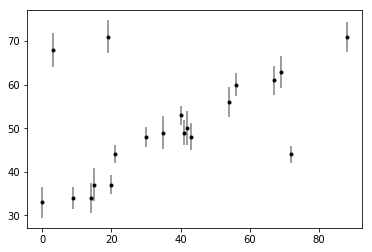

In [2]:
import numpy as np
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])


%matplotlib inline
import matplotlib.pyplot as plt
plt.errorbar(x, y,e, fmt='.k', ecolor='gray');



from scipy import optimize

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss') 

theta1

t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

plt.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label="Huber loss, c={0}".format(c), lw=2)
plt.ylabel('loss')
plt.xlabel('standard deviations')
plt.legend(loc='best', frameon=False);


def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

test=np.arange(10)
print(test)

test[2:]

len(x)

# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)



# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
print(sample.shape)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
print(sample.shape)



plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');




plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))
print("g3 mean: {0:.2f}".format(sample[:, 4].mean()))
print("g4 mean: {0:.2f}".format(sample[:, 5].mean()))










theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.5)
xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');



import corner
#intercept=sample[:,0]
#slope=sample[:,1]
fig = corner.corner(sample[:,:2], labels=["$Intercept$", "$Slope$",],
                      truths=[31.2, 0.48])
fig.show()

In [ ]:
theta3

In [ ]:
theta30=sample[:,0]
theta31=sample[:,1]
#theta30.shape
plt.hist2d(theta30,theta31,bins=(500,500),range=((25,40),(0.3,0.6)))

In [ ]:
plt.hist(theta30,bins=100)

In [ ]:
plt.hist(theta31,bins=100)

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def p(x, theta):
    return (x > theta) * np.exp(theta - x)

x = np.linspace(5, 18, 1000)
plt.fill(x, p(x, 10), alpha=0.3)
plt.ylim(0, 1.2)
plt.xlabel('x')
plt.ylabel('p(x)');


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

In [ ]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');

In [ ]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

In [ ]:
import emcee
print(emcee.__version__)

In [ ]:
# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)



In [ ]:

# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))



In [ ]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

In [ ]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(xdata, ydata, emcee_trace)

In [ ]:
import pymc
print(pymc.__version__)

In [ ]:
# Define the variables needed for the routine, with their prior distributions
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, value=ydata)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma,
              y_model=y_model, y=y)

In [ ]:
# run the basic MCMC: we'll do 100000 iterations to match emcee above
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)

In [ ]:
# extract the traces and plot the results
pymc_trace = [S.trace('alpha')[:],
              S.trace('beta')[:],
              S.trace('sigma')[:]]

plot_MCMC_results(xdata, ydata, pymc_trace)

In [ ]:
import pystan
print(pystan.__version__)

In [ ]:
from sklearn import linear_model
import numpy as np


In [ ]:
x=np.random.rand(2,20)*10+5
y=3+0.6*x[0]+1.1*x[1]+np.random.normal(0,1,20)*0.1 



In [ ]:
X=[[0,0],[1,1],[2,2],[3,3]]
Y=[0,1,2,3]

In [ ]:
reg=linear_model.BayesianRidge()
reg.fit(X,Y)

In [ ]:
reg.coef_

bmcmc not suitable for py3

In [ ]:
import bmcmc
class stlineb(bmcmc.Model):
  def set_descr(self):
      # setup descriptor
      self.descr['m']      =['l0', 1.0, 0.2,'$m$',        -1e10,1e10]
      self.descr['c']      =['l0',10.0, 1.0,'$c$',        -1e10,1e10]
      self.descr['mu_b']   =['l0', 1.0, 1.0,'$\mu_b$',    -1e10,1e10]
      self.descr['sigma_b']=['l0', 1.0, 1.0,'$\sigma_b$', 1e-10,1e10]
      self.descr['p_b']    =['l0',0.1,0.01,'$P_b$',      1e-10,0.999]

  def set_args(self):
      # setup data points
      np.random.seed(11)
      self.args['x']=0.5+np.random.ranf(self.eargs['dsize'])*9.5
      self.args['sigma_y']=0.25+np.random.ranf(self.eargs['dsize'])
      self.args['y']=np.random.normal(self.args['x']*2+10,self.args['sigma_y'])
      # add outliers
      self.ind=np.array([0,2,4,6,8,10,12,14,16,18])
      self.args['y'][self.ind]=np.random.normal(30,5,self.ind.size)
      self.args['y'][self.ind]=self.args['y'][self.ind]+np.random.normal(0.0,self.args['sigma_y'][self.ind])

  def lnfunc(self,args):
      # log posterior
      if self.eargs['outliers'] == False:
          temp1=(args['y']-(self.args['m']*self.args['x']+self.args['c']))/args['sigma_y']
          return -0.5*(temp1*temp1)-np.log(np.sqrt(2*np.pi)*args['sigma_y'])
      else:
          temp11=scipy.stats.norm.pdf(args['y'],loc=(self.args['m']*self.args['x']+self.args['c']),scale=args['sigma_y'])
          sigma_b=np.sqrt(np.square(args['sigma_y'])+np.square(args['sigma_b']))
          temp22=scipy.stats.norm.pdf(args['y'],loc=self.args['mu_b'],scale=sigma_b)
          return np.log((1-args['p_b'])*temp11+args['p_b']*temp22)

  def myplot(self,chain):
     # optional method for plotting
     # plot best fit line corrsponding to chain of this model
      plt.clf()
      x = np.linspace(0,10)
      burn=self.chain['m'].size/2
      vals=self.best_fit(burn=burn)
      plt.errorbar(self.args['x'], self.args['y'], yerr=self.args['sigma_y'], fmt=".k")
      plt.errorbar(self.args['x'][self.ind], self.args['y'][self.ind], yerr=self.args['sigma_y'][self.ind], fmt=".r")
      plt.plot(x,vals[0]*x+vals[1], color="g", lw=2, alpha=0.5)
      for i,key in enumerate(self.names0):
          print(key)
          plt.text(0.5,0.3-i*0.06,self.descr[key][3]+'='+bmcmc.stat_text(self.chain[key][burn:]),transform=plt.gca().transAxes)

     # plot best fit line corrsponding to some other chain
      vals1=[]
      burn1=chain['m'].size/2
      for i,key in enumerate(['m','c']):
          print(key)
          plt.text(0.05,0.5-i*0.05,self.descr[key][3]+'='+bmcmc.stat_text(chain[key][burn1:]),transform=plt.gca().transAxes)
          vals1.append(np.mean(chain[key][burn1:]))
      plt.plot(x,vals1[0]*x+vals1[1], 'g--', lw=2, alpha=0.5)
      plt.xlabel(r'$x$')
      plt.ylabel(r'$y$')
      plt.axis([0,10,5,40,])